In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pyBigWig
import pysam
from tqdm import tqdm
from scipy import stats

## Coverage Uniformity

In [2]:
with open('../bin/benchmarking/PTA_names.txt', 'r') as fin:
    PTA_names = [line.strip() for line in fin if line.strip() != 'SRR8438299']
with open('../bin/benchmarking/LIANTI_names.txt', 'r') as fin:
    LIANTI_names = [line.strip() for line in fin]
with open('../bin/K562_tree/real_cells.txt', 'r') as fin:
    shallow_CapWGS_names = [line.strip() for line in fin]

names = PTA_names + LIANTI_names + shallow_CapWGS_names

In [3]:
pal = {
    'PTA': '#5AAA46',
    'MDA': '#F2B342',
    'LIANTI': '#C03830',
    'MALBAC': '#C43E96',
    'Bulk': '#825CA6',
    'shallow_CapWGS': '#317EC2'
}

In [4]:
meta_1 = pd.read_csv('../bin/benchmarking/PTA_meta.tsv', sep='\t', index_col='SRA_Run')
meta_1=meta_1[meta_1['amplification_method'].isin(['PTA','SCMDA'])]
def rename(row):
    if row.amplification_method=='SCMDA':
        return 'MDA' 
    else:
        return row.amplification_method
meta_1['amplification_method'] = meta_1.apply(rename, axis=1)
meta_1['study']='Gonzalez-Pena'
meta_1=meta_1[['study','amplification_method']]
# meta_1

In [5]:
meta_2 = pd.read_csv('../bin/benchmarking/LIANTI_meta.tsv', sep='\t', index_col='SRA_Run')
meta_2['study'] = 'Chen'

def amp(row):
    if 'LIANTI' in row.replicate:
        return 'LIANTI' 
    elif 'MDA' in row.replicate:
        return 'MDA' 
    elif 'MALBAC' in row.replicate:
        return 'MALBAC'
    elif 'Bulk' in row.replicate:
        return 'Bulk'
    
meta_2['amplification_method'] = meta_2.apply(amp, axis=1)
meta_2 = meta_2[meta_2['amplification_method'].isin(['LIANTI','MDA','MALBAC','Bulk'])]
meta_2 = meta_2[['study','amplification_method']]
# meta_2

In [6]:
meta_3 = pd.DataFrame(index=shallow_CapWGS_names)
meta_3['amplification_method'] = "shallow_CapWGS"
meta_3['study'] = "CapWGS"


In [7]:
meta = pd.concat([meta_1, meta_2, meta_3])
meta

,study,amplification_method
SRR8438254,Gonzalez-Pena,PTA
SRR8438256,Gonzalez-Pena,PTA
SRR8438258,Gonzalez-Pena,PTA
SRR8438259,Gonzalez-Pena,PTA
SRR8438298,Gonzalez-Pena,PTA
...,...,...
ATACGACCAGGAAGACCGATACTCGTGTGATGAAGGTTCCACTCA,CapWGS,shallow_CapWGS
AAGGCTTGAGGATGGTCACTACTCGTGTGATGAAGGGTTACGGTA,CapWGS,shallow_CapWGS
CAACTTGCAGGAATGGTGTGACTCCACCATCTAAGGTTGGATGCA,CapWGS,shallow_CapWGS
CAACTTGCAGGAAACGATGGACTCTACAACCGAAGGTCCAGGATA,CapWGS,shallow_CapWGS


In [13]:
meta.to_csv('../results/benchmarking/benchmarking_metadata.csv')

In [8]:
coverages_1 = {name : pd.read_csv(f"../data/benchmarking/binned_coverage/{name}.csv", header=None)[0].to_list() for name in meta[meta['study'].isin(['Gonzalez-Pena', 'Chen'])].index}
coverages_1 = pd.DataFrame(data=coverages_1)

# coverages_1

In [9]:
coverages_2 = {name : pd.read_csv(f"../data/K562_tree/binned_coverage/{name}.csv", header=None)[0].to_list() for name in meta[meta['study']=='CapWGS'].index}
coverages_2 = pd.DataFrame(data=coverages_2)

In [10]:
coverages = pd.concat([coverages_1,coverages_2])

In [11]:
lorenz_curves = {}
ginis = []
for name in meta.index:
    prop = coverages[name] / coverages[name].sum()
    prop = prop[prop>0] 
    y = np.cumsum(prop.sort_values())
    x = np.arange(len(prop))
    x = x / len(x)
    x = np.concatenate(([0], x))
    y = np.concatenate(([0], y))
    lorenz_curves[name] = y
    auc = np.trapezoid(y, x)
    gini = 1 - 2 * auc
    ginis.append(gini)
    
meta['gini'] = ginis

common_x = np.linspace(0, 1, 100)

for name,arr in lorenz_curves.items():
    # Original x scale for the array (0 to 1, evenly spaced)
    original_x = np.linspace(0, 1, len(arr))
    # Interpolate to the common scale
    rescaled_y = np.interp(common_x, original_x, arr)
    lorenz_curves[name]=rescaled_y

lorenz_curves = pd.DataFrame(data=lorenz_curves, index=common_x)

In [15]:
lorenz_curves.to_csv('../results/benchmarking/lorenz_curves.csv')

In [15]:
del converages

/loc/scratch/40415726/ipykernel_34277/2125829502.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=meta, x="amplification_method", y="gini", order=['Bulk','shallow_CapWGS','LIANTI','PTA','MDA','MALBAC'],


Text(0, 0.5, 'Gini Coefficient')

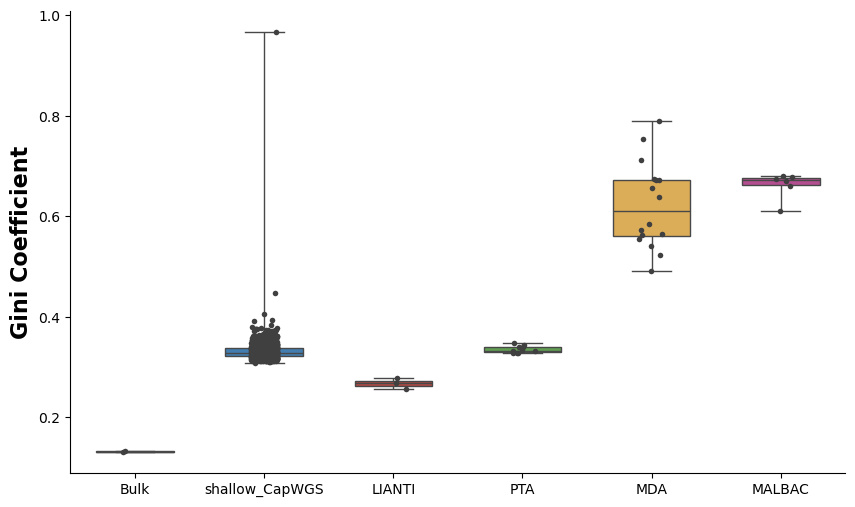

In [16]:
# sns.set_theme(style="ticks", palette="pastel")
fig,ax = plt.subplots(1,1,figsize=(10,6))
sns.boxplot(data=meta, x="amplification_method", y="gini", order=['Bulk','shallow_CapWGS','LIANTI','PTA','MDA','MALBAC'],
            ax=ax,
            palette=pal,
            whis=(0,100),
            width=.6
           )

sns.stripplot(data=meta, x="amplification_method", y="gini", order=['Bulk','shallow_CapWGS','LIANTI','PTA','MDA','MALBAC'],
              ax=ax,
              size=4, 
              color=".25"
             )

sns.despine()
plt.xlabel('')
# plt.ylim(0.175,0.4)
plt.ylabel('Gini Coefficient', fontdict={'weight':'bold','size':16})

Text(0, 0.5, 'Cumulative Fraction of Total Reads')

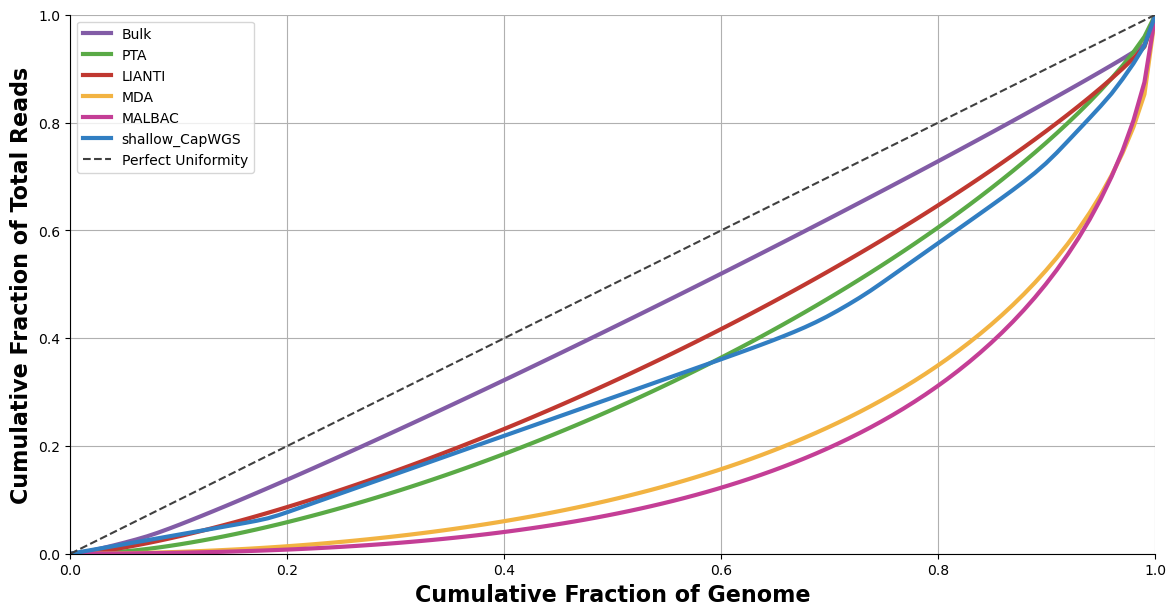

In [17]:
# Calculate mean and standard deviation of Lorenz curves for each group
mean_curves = {}
std_curves = {}
for group in meta['amplification_method'].unique():
    subset = lorenz_curves[meta[meta['amplification_method']==group].index]  # Select Lorenz curves for the group
    mean_curves[group] = subset.mean(axis=1)  # Mean across barcodes
    std_curves[group] = subset.std(axis=1)    # Standard deviation across barcodes

# Convert to DataFrame for plotting
mean_df = pd.DataFrame(mean_curves)
std_df = pd.DataFrame(std_curves)

plt.figure(figsize=(14, 7))
plt.plot(common_x, mean_df['Bulk'], label='Bulk', color=pal['Bulk'], linewidth=3)
plt.plot(common_x, mean_df['PTA'], label='PTA', color=pal['PTA'], linewidth=3)
plt.plot(common_x, mean_df['LIANTI'], label='LIANTI', color=pal['LIANTI'], linewidth=3)
plt.plot(common_x, mean_df['MDA'], label='MDA', color=pal['MDA'], linewidth=3)
plt.plot(common_x, mean_df['MALBAC'], label='MALBAC', color=pal['MALBAC'], linewidth=3)
plt.plot(common_x, mean_df['shallow_CapWGS'], label='shallow_CapWGS', color=pal['shallow_CapWGS'], linewidth=3)
plt.grid(True)
plt.plot([0,1],[0,1], color='.25', linestyle='--', label='Perfect Uniformity')
plt.legend(title='')
sns.despine()
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('Cumulative Fraction of Genome', fontdict={'weight':'bold','size':16})
plt.ylabel('Cumulative Fraction of Total Reads', fontdict={'weight':'bold','size':16})

## GC Bias, % mapping, % duplicates, etc

In [18]:
PTA_metrics = pd.read_csv('../results/benchmarking/PTA_qc_summary.csv', index_col=0)
PTA_metrics = PTA_metrics[PTA_metrics.index.isin(meta.index)]
# PTA_metrics

In [19]:
LIANTI_metrics = pd.read_csv('../results/benchmarking/LIANTI_qc_summary.csv', index_col=0)
LIANTI_metrics = LIANTI_metrics[LIANTI_metrics.index.isin(meta.index)]
# PTA_metrics

In [20]:
CapWGS_metrics = pd.read_csv('../results/K562_tree_qc_summary.csv', index_col=0)
CapWGS_metrics = CapWGS_metrics[CapWGS_metrics.index.isin(meta.index)]

In [21]:
metrics = pd.concat([PTA_metrics, LIANTI_metrics, CapWGS_metrics])
meta = pd.merge(meta, metrics, left_index=True, right_index=True)
meta

,study,amplification_method,gini,pct_reads_aligned,mean_read_length,reads_aligned,total_reads,at_dropout,gc_dropout,pct_duplicates,read_pairs_examined,read_pair_duplicates,mean_coverage,median_coverage,pct_1x,pct_10x
SRR8438254,Gonzalez-Pena,PTA,0.340152,0.998890,142.328266,393373122,393810332,2.463873,3.953465,0.264538,393058249.0,103906582.0,29.582088,24.0,0.944510,0.777034
SRR8438256,Gonzalez-Pena,PTA,0.348410,0.998999,142.087322,376201472,376578419,3.084621,2.600622,0.172425,375853409.0,64717620.0,28.365647,22.0,0.946975,0.772341
SRR8438258,Gonzalez-Pena,PTA,0.331572,0.998965,142.257909,397358060,397769597,2.353022,4.301985,0.211232,396960198.0,83758787.0,30.239498,25.0,0.947363,0.788415
SRR8438259,Gonzalez-Pena,PTA,0.339419,0.998896,141.950284,403413288,403859008,2.474044,4.007757,0.222852,403083571.0,89745871.0,30.415738,25.0,0.945227,0.783495
SRR8438298,Gonzalez-Pena,PTA,0.327987,0.998929,142.211162,390038638,390456866,2.505916,4.156542,0.194874,389678898.0,75850471.0,29.205149,24.0,0.947178,0.785615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATACGACCAGGAAGACCGATACTCGTGTGATGAAGGTTCCACTCA,CapWGS,shallow_CapWGS,0.316702,0.999730,153.586460,122093,122126,2.306170,7.740027,0.345752,122037.0,42192.0,0.007259,0.0,0.004578,0.000002
AAGGCTTGAGGATGGTCACTACTCGTGTGATGAAGGGTTACGGTA,CapWGS,shallow_CapWGS,0.312225,0.999572,153.653773,121374,121426,2.449821,8.144113,0.341810,121336.0,41471.0,0.007272,0.0,0.004622,0.000002
CAACTTGCAGGAATGGTGTGACTCCACCATCTAAGGTTGGATGCA,CapWGS,shallow_CapWGS,0.314922,0.999773,153.597466,123512,123540,2.321385,8.081127,0.347162,123464.0,42862.0,0.007548,0.0,0.004754,0.000003
CAACTTGCAGGAAACGATGGACTCTACAACCGAAGGTCCAGGATA,CapWGS,shallow_CapWGS,0.313712,0.999720,153.601749,121490,121524,1.675470,7.344514,0.343545,121444.0,41720.0,0.007168,0.0,0.004549,0.000002


In [28]:
print(f"Gonzalez-Pena reads per cell: {meta[meta['study']=='Gonzalez-Pena']['read_pairs_examined'].mean():.0f}")
print(f"Gonzalez-Pena coverage per cell: {meta[meta['study']=='Gonzalez-Pena']['mean_coverage'].mean():.0f}")
print('\n')
print(f"Chen reads per cell: {meta[meta['study']=='Chen']['read_pairs_examined'].mean():.0f}")
print(f"Chen coverage per cell: {meta[meta['study']=='Chen']['mean_coverage'].mean():.0f}")
print('\n')
print(f"CapWGS reads per cell: {meta[meta['study']=='CapWGS']['read_pairs_examined'].mean():.0f}")
print(f"CapWGS coverage per cell: {meta[meta['study']=='CapWGS']['mean_coverage'].mean():.3f}")

Gonzalez-Pena reads per cell: 473045355
Gonzalez-Pena coverage per cell: 25


Chen reads per cell: 305379847
Chen coverage per cell: 13


CapWGS reads per cell: 392726
CapWGS coverage per cell: 0.023


GcBiasSummaryMetrics - AT_DROPOUT/GC_DROPOUT

(%ref_at_gc - %reads_at_gc) and summing all positive values

/loc/scratch/40415726/ipykernel_34277/3984457094.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=meta, x="amplification_method", y="pct_reads_aligned", order=['Bulk','shallow_CapWGS','LIANTI','PTA','MDA','MALBAC'],


Text(0, 0.5, 'Proportion of reads aligning to reference')

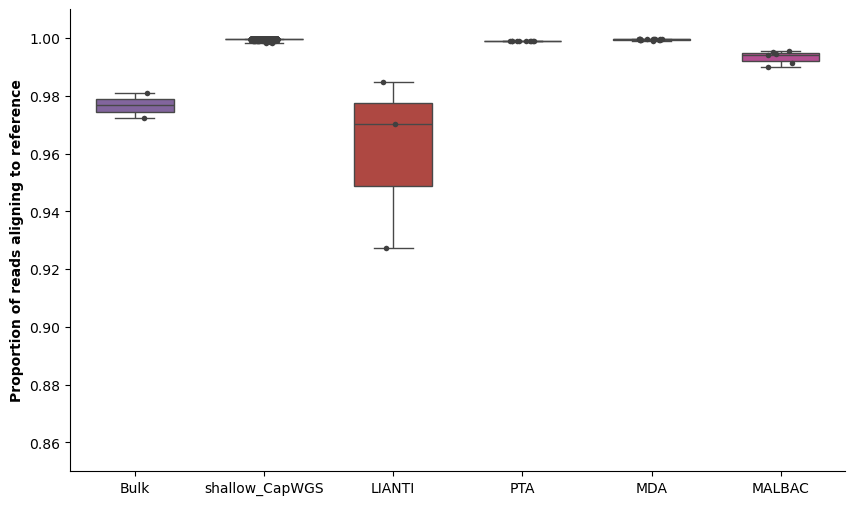

In [30]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
sns.boxplot(data=meta, x="amplification_method", y="pct_reads_aligned", order=['Bulk','shallow_CapWGS','LIANTI','PTA','MDA','MALBAC'],
            ax=ax,
            palette=pal,
            whis=(0,100),
            width=.6
           )

sns.stripplot(data=meta, x="amplification_method", y="pct_reads_aligned", order=['Bulk','shallow_CapWGS','LIANTI','PTA','MDA','MALBAC'],
              ax=ax,
              size=4, 
              color=".25"
             )

sns.despine()
plt.xlabel('')
plt.ylim(0.85,1.01)
plt.ylabel('Proportion of reads aligning to reference', fontdict={'weight':'bold'})

/loc/scratch/40415726/ipykernel_34277/2007687686.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=meta, x="amplification_method", y="pct_duplicates", order=['Bulk','shallow_CapWGS','LIANTI','PTA','MDA','MALBAC'],


Text(0, 0.5, 'Proportion duplicates')

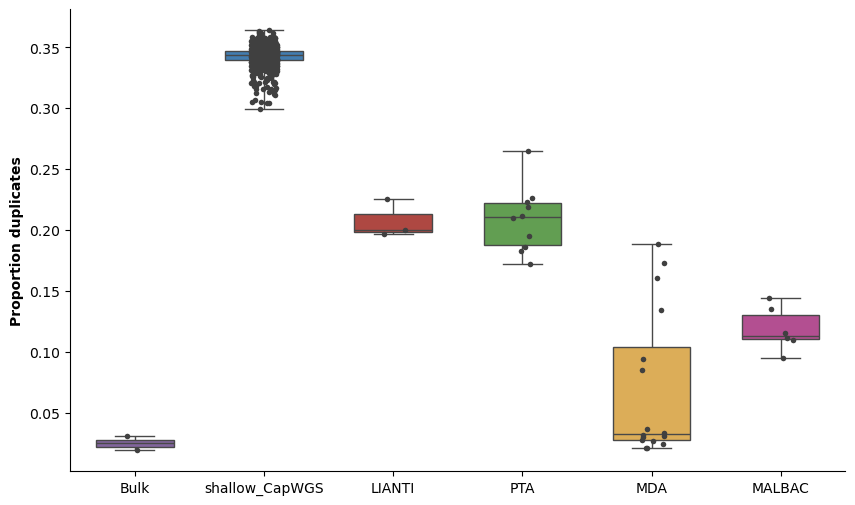

In [31]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
sns.boxplot(data=meta, x="amplification_method", y="pct_duplicates", order=['Bulk','shallow_CapWGS','LIANTI','PTA','MDA','MALBAC'],
            ax=ax,
            palette=pal,
            whis=(0,100),
            width=.6
           )

sns.stripplot(data=meta, x="amplification_method", y="pct_duplicates", order=['Bulk','shallow_CapWGS','LIANTI','PTA','MDA','MALBAC'],
              ax=ax,
              size=4, 
              color=".25"
             )

sns.despine()
plt.xlabel('')
# plt.ylim(0.85,1.01)
plt.ylabel('Proportion duplicates', fontdict={'weight':'bold'})

/loc/scratch/40415726/ipykernel_34277/3193394668.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=meta, x="amplification_method", y="gc_dropout", order=['Bulk','shallow_CapWGS','LIANTI','PTA','MDA','MALBAC'],


Text(0, 0.5, 'GC dropout')

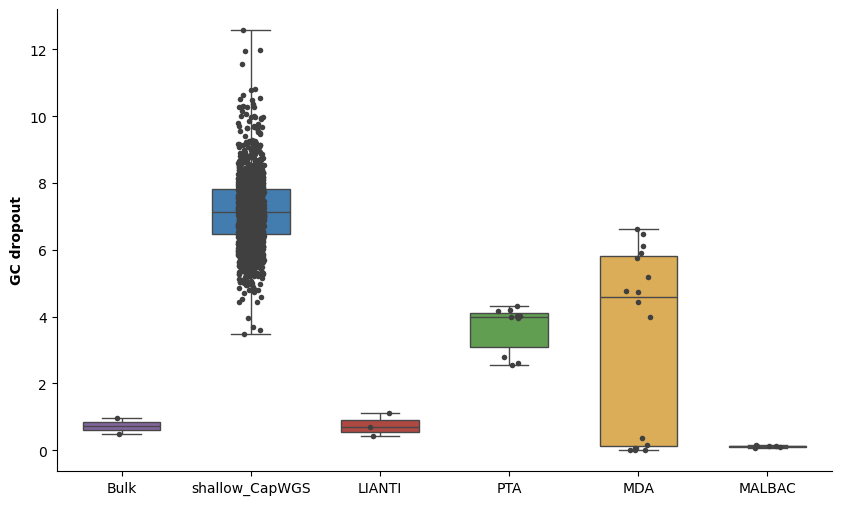

In [32]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
sns.boxplot(data=meta, x="amplification_method", y="gc_dropout", order=['Bulk','shallow_CapWGS','LIANTI','PTA','MDA','MALBAC'],
            ax=ax,
            palette=pal,
            whis=(0,100),
            width=.6
           )

sns.stripplot(data=meta, x="amplification_method", y="gc_dropout", order=['Bulk','shallow_CapWGS','LIANTI','PTA','MDA','MALBAC'],
              ax=ax,
              size=4, 
              color=".25"
             )

sns.despine()
plt.xlabel('')
# plt.ylim(0.85,1.01)
plt.ylabel('GC dropout', fontdict={'weight':'bold'})